In [1]:
import math, random
import numpy as np
from collections import defaultdict
from math import log2
import torch
import matplotlib.pyplot as plt

random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
user_items = dict()
with open("train-1.txt", "r", encoding="utf-8") as g:
    for line in g:
        tokens = line.strip().split()
        u, items = tokens[0], tokens[1:]
        user_items[u] = set(items)

In [3]:
train_ui, test_ui = dict(), dict()
for u, items in user_items.items():
    items = list(items)
    if len(items) <= 1:
        train_ui[u] = set(items)
        continue
    n_test = max(1, int(len(items)*0.2))
    tset = set(random.sample(items, n_test))
    tr = set(items) - tset
    if tr:
        train_ui[u] = tr
        if tset:
            test_ui[u] = tset

In [4]:
# ---------- metrics ----------
def average_ndcg(recs, test, k=20):
    vals = list()
    for u, rlist in recs.items():
        gt = test.get(u, set())
        if gt:
            dcg = 0.0
            for i in range(min(k, len(rlist))):
                if rlist[i] in gt:
                    dcg += 1.0 / log2(i+2)
            ideal = min(len(gt), k)
            if ideal == 0: 
                return 0.0
            idcg = sum(1.0 / log2(i+2) for i in range(ideal))
            middle = dcg / idcg
            vals.append(middle)
    return round(float(np.mean(vals)), 5) if vals else 0.0

In [5]:
def cosine(a,b,c):
    return c / math.sqrt(a*b) if a and b else 0.0

def jaccard(a,b,c):
    u = a + b - c
    return c / u if u else 0.0

def pearson(N,a,b,c):
    if a == 0 or b == 0 or a == N or b == N:
        return 0.0
    num = c - (a*b)/N
    den = math.sqrt(a*(1 - a/N) * b*(1 - b/N))
    return num/den if den else 0.0

In [6]:
def build_neighbors(train_ui, k, sim_type):
    N = len(train_ui)
    co = defaultdict(lambda: defaultdict(int))
    deg = defaultdict(int)
    items_all = set()
    for _, items in train_ui.items():
        s = sorted(items)
        items_all.update(s)
        for it in s:
            deg[it] += 1
        for i in range(len(s)):
            a = s[i]
            for j in range(i+1, len(s)):
                b = s[j]
                co[a][b] += 1
    if sim_type == "cosine":
        sim_fn = lambda a,b,c: cosine(a,b,c)
    elif sim_type == "jaccard":
        sim_fn = lambda a,b,c: jaccard(a,b,c)
    else:
        sim_fn = lambda a,b,c: pearson(N,a,b,c)

    nbrs = defaultdict(list)
    for i, row in co.items():
        ai = deg[i]
        for j, c in row.items():
            aj = deg[j]
            s = sim_fn(ai, aj, c)
            if s != 0.0:
                nbrs[i].append((j, s))
                nbrs[j].append((i, s))
    for it in list(nbrs.keys()):
        nbrs[it].sort(key=lambda t: abs(t[1]), reverse=True)
        nbrs[it] = nbrs[it][:k]
    popular = [it for it,_ in sorted(deg.items(), key=lambda kv: (-kv[1], kv[0]))]
    return nbrs, popular

In [7]:
def utility(idx_list, items_u, idx2item, topn, pop_idx):
    ids = list()
    seen = items_u
    for j in idx_list:
        ids.append(idx2item[j])
        if len(ids) == topn:
            break
    if len(ids) < topn:
        have = set(ids) | seen
        for j in pop_idx:
            it = idx2item[j]
            if it not in have:
                ids.append(it)
                if len(ids) == topn:
                    break
    return ids

In [ ]:
def recommend_all_gpu(train_user_items, item_ids, item2idx, nbr_idx, nbr_val, popular_items, topn=20):
    idx2item = item_ids

    # Make a popularity backfill list in indices (faster on GPU/CPU mix)
    pop_idx = [item2idx[it] for it in popular_items if it in item2idx]
    all_recs = dict()
    for u, items_u in train_user_items.items():
        # indices first
        I, K = nbr_idx.shape

        if not items_u:
            # cold start: backfill by popularity
            idx_list = (popular_items or [])[:topn]
            all_recs[u] = utility(idx_list, items_u, idx2item, topn, pop_idx)

        # Map seen items -> indices
        seen_idx = [item2idx[it] for it in items_u if it in item2idx]
        if not seen_idx:
            idx_list = (popular_items or [])[:topn]
            all_recs[u] = utility(idx_list, items_u, idx2item, topn, pop_idx)

        seen_idx_t = torch.tensor(seen_idx, dtype=torch.long, device=device)  # (m,)

        # Gather neighbor rows for all seen items -> (m, K)
        nb_j   = nbr_idx.index_select(0, seen_idx_t)   # neighbor indices (padded with -1)
        nb_sim = nbr_val.index_select(0, seen_idx_t)   # neighbor weights (padded with 0)

        # Flatten contributions
        flat_j   = nb_j.reshape(-1)                    # (m*K,)
        flat_sim = nb_sim.reshape(-1)

        # Drop pads (-1)
        valid = flat_j >= 0
        flat_j   = flat_j[valid]                       # candidate indices
        flat_sim = flat_sim[valid]                     # their contributions

        # Mask out already-seen candidates
        seen_mask = torch.zeros(I, dtype=torch.bool, device=device)
        seen_mask[seen_idx_t] = True
        not_seen = ~seen_mask[flat_j]
        flat_j   = flat_j[not_seen]
        flat_sim = flat_sim[not_seen]

        if flat_j.numel() == 0:
            # no candidates via neighbors -> popularity backfill
            idx_list = [it for it in (popular_items or []) if it not in items_u][:topn]
            all_recs[u] = utility(idx_list, items_u, idx2item, topn, pop_idx)

        # Aggregate: sum(sim) and sum(|sim|) per candidate (for normalization)
        scores = torch.zeros(I, dtype=torch.float32, device=device)
        norms  = torch.zeros(I, dtype=torch.float32, device=device)
        scores.scatter_add_(0, flat_j, flat_sim)
        norms.scatter_add_(0, flat_j, flat_sim.abs())

        # Normalize; set seen to -inf so they're never recommended
        denom = torch.where(norms > 0, norms, torch.ones_like(norms))
        final_scores = scores / denom
        final_scores[seen_idx_t] = -float("inf")

        # Top-N
        n_eff = min(topn, I)
        top_scores, top_idx = torch.topk(final_scores, n_eff, largest=True)
        # Filter any -inf (in case user interacted with almost everything)
        mask_finite = torch.isfinite(top_scores) & (top_scores > -1e30)
        top_idx = top_idx[mask_finite].tolist()

        # Backfill with popularity if needed
        if popular_items:
            # convert indices -> ids
            # We need the id list from prepare_torch_neighbors
            # We'll pass it as a closure, or return it from the caller.
            pass

        idx_list = top_idx
        all_recs[u] = utility(idx_list, items_u, idx2item, topn, pop_idx)
    return all_recs

In [9]:
def prepare_torch_neighbors(neighbors, all_items=None, k=None):
    # Build a stable item index (0..I-1)
    if all_items is None:
        item_ids = sorted(neighbors.keys())
    else:
        item_ids = sorted(all_items)
    item2idx = {it: i for i, it in enumerate(item_ids)}
    I = len(item_ids)

    # Determine K from data if not provided
    if k is None:
        k = max((len(v) for v in neighbors.values()), default=0)

    # Allocate (-1 / 0 padding)
    nbr_idx = torch.full((I, k), -1, dtype=torch.long, device=device)
    nbr_val = torch.zeros((I, k), dtype=torch.float32, device=device)

    for it, lst in neighbors.items():
        i = item2idx[it]
        # lst: list[(nbr_item, sim)] — we will keep up to k
        upto = min(k, len(lst))
        if upto == 0: 
            continue
        idxs = [item2idx[nbr] for (nbr, _) in lst[:upto]]
        vals = [float(sim) for (_, sim) in lst[:upto]]
        nbr_idx[i, :upto] = torch.tensor(idxs, dtype=torch.long, device=device)
        nbr_val[i, :upto] = torch.tensor(vals, dtype=torch.float32, device=device)

    return item_ids, item2idx, nbr_idx, nbr_val

In [10]:
K_VALUES = [5, 10, 20, 30, 40, 50, 75, 100]
topN = 20
ndcg_cosine, ndcg_jaccard, ndcg_pearson = list(), list(), list()

for k in K_VALUES:
    for sim_metric in ["cosine", "jaccard", "pearson"]:
        nbrs, pop = build_neighbors(train_ui, k, sim_metric)
        # Prepare neighbor tensors on GPU (once per k/sim_type)
        item_ids, item2idx, nbr_idx, nbr_val = prepare_torch_neighbors(
            nbrs, all_items=None, k=k)
        # ensure popularity refers only to items present in neighbor map
        popular_items = [it for it in pop if it in item2idx]
        recs = recommend_all_gpu(train_user_items=train_ui,
            item_ids=item_ids,
            item2idx=item2idx,
            nbr_idx=nbr_idx,
            nbr_val=nbr_val,
            popular_items=popular_items,
            topn=topN)
        if sim_metric == "cosine":
            ndcg_cosine.append(average_ndcg(recs, test_ui, topN))
        elif sim_metric == "jaccard":
            ndcg_jaccard.append(average_ndcg(recs, test_ui, topN))
        else:
            ndcg_pearson.append(average_ndcg(recs, test_ui, topN))

In [11]:
print(f"K_VALUES        = {K_VALUES}")
print("ndcg@20, cosine = ", ndcg_cosine)
print("ndcg@20, jaccard = ", ndcg_jaccard)
print("ndcg@20, pearson = ", ndcg_pearson)

K_VALUES        = [5, 10, 20, 30, 40, 50, 75, 100]
ndcg@20, cosine =  [0.01854, 0.0164, 0.01513, 0.01496, 0.01491, 0.01482, 0.0151, 0.01518]
ndcg@20, jaccard =  [0.02112, 0.01826, 0.01627, 0.01562, 0.01595, 0.01614, 0.01606, 0.01609]
ndcg@20, pearson =  [0.01839, 0.01584, 0.01481, 0.01427, 0.01416, 0.0142, 0.0141, 0.01432]


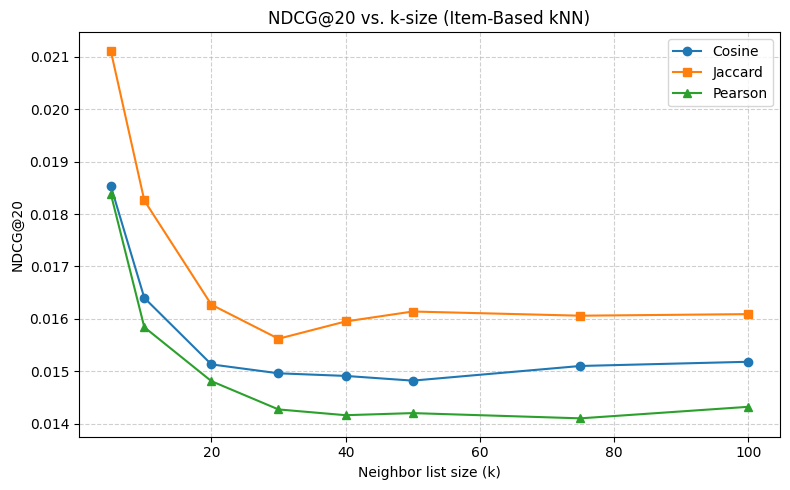

In [12]:
# ---------- plot ----------
plt.figure(figsize=(8,5))
plt.plot(K_VALUES, ndcg_cosine, marker="o", label="Cosine")
plt.plot(K_VALUES, ndcg_jaccard, marker="s", label="Jaccard")
plt.plot(K_VALUES, ndcg_pearson, marker="^", label="Pearson")
plt.xlabel("Neighbor list size (k)")
plt.ylabel("NDCG@20")
plt.title("NDCG@20 vs. k-size (Item-Based kNN)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()